# Assignment 2A Group 13

* Rivka Vollebregt, 8842507
* Jacob Hemming, 6433383
* Jorrit Jan Walinga, 6498027
* Sunny Hsieh, 6534856

a2ee308b-db84-4aba-95da-fd2e77c2ad72


# Vectorial Word Representations

## Background
Representing words as dense vectors over a finite-dimensional space was one of the recent breakthroughs in Natural Language Processing. Vectorial representations allow space-efficient, informationally rich storage of words that adequately captures their semantic content and enables numerical computation on them. Word vectors are the standard input representation for machine learning architectures for language processing. Even though new methods for constructing such representations emerge frequently, the original set of published papers remain a de facto point of reference as well as a good starting point. For this assignment, you will be asked to implement a small-scale variant of one such paper, namely [Global Word Vectors for Word Representation](https://nlp.stanford.edu/pubs/glove.pdf) ("the GloVe paper").

Much of the code and data pre-processing has already been done for you. Additionally, notes on the paper will appear throughout the notebook to guide you along the code. It is, however, important to read and understand the paper, its terminology and the theory behind it before attempting to go through with the assignment. Some of the tasks will also require addressing the paper directly.

**-------------------------------------------------------------------------------------------------------------**

There are 2 types of tasks in this assignment: 
- coding tasks --- 10 tasks worth 1 point each --- asking you to write code following specifications provided; make sure to <ins>show the code to your teacher after completing every coding task</ins>
- interpretation questions --- 5 questions worth 1 point each --- asking you to interpret the data or the results of the model

You are greatly encouraged to add comments to your code describing what particular lines of code do (in general, a great habit to have in your coding life), as well as self-check regularly by printing your tensors and their shapes making sure they look adequate.

## Corpus Statistics

The paper's proposed model, GloVe, aims to densely represent words in a way that captures the global corpus statistics. 

The construction it encodes is the word __co-occurrence matrix__. A co-occurrence matrix is a simplistic data structure that counts the number of times each word has appeared within the context of every other word. The definition of a context varies; usually, context is implied to be a fixed-length span (that may or may not be allowed to escape sentence boundaries) around a word. 

For instance, in the sentence below and for a context length of 2, the word <span style="color:pink">__Earth__</span> occurs in the context of <span style="color:lightgreen">made</span> (1), <span style="color:lightgreen">on</span> (1), <span style="color:lightgreen">as</span> (1), <span style="color:lightgreen">an</span> (1).

> "He struck most of the friends he had <span style="color:lightgreen">made on</span> <span style="color:pink">__Earth__</span> <span style="color:lightgreen">as an</span> eccentric"

Similarly, the word <span style="color:pink">__friends__</span> occurs in the context of <span style="color:lightgreen">of</span> (1), <span style="color:lightgreen">the</span> (1), <span style="color:lightgreen">he</span> (1), <span style="color:lightgreen">had</span> (1).

> "He struck most <span style="color:lightgreen">of the</span> <span style="color:pink">__friends__</span> <span style="color:lightgreen">he had</span> made on Earth as an eccentric"

An alternative definition of a context would be, for instance, the variable-length windows spanned by a full sentence.

Contexts may be summed across sentences or entire corpora; the summed context of <span style="color:pink">he</span> in the example sentence is: <span style="color:lightgreen">struck</span> (1), <span style="color:lightgreen">most</span> (1), <span style="color:lightgreen">the</span> (1), <span style="color:lightgreen">friends</span> (1), <span style="color:lightgreen">had</span> (1), <span style="color:lightgreen">made</span> (1).



For the purposes of this assignment, we have prepared a co-occurrence matrix over a minimally processed version of the Harry Potter books.

(A few interpretation tasks in this assignment presuppose some minimal level of familiarity with the Harry Potter books/films. If no one in your group is familiar with Harry Potter, please talk to your teacher)

The pickle file contains three items:
1. `vocab`: a dictionary mapping words to unique ids, containing $N$ unique words
2. `contexts`: a dictionary mapping words to their contexts, where contexts are themselves dicts from words to integers that show the number of co-occurrences between these words.
    E.g. `{"portrait": {"harry": 103, "said": 97, ...}, ...}` meaning that the word "harry" has appeared in the context of the word "portrait" 103 times, etc.
3. `X`: a torch LongTensor ${X}$ of size $N \times N$, where ${X}[i,j]$ denotes the number of times the word with id $j$ has appeared in the context of the word with id $i$

Extremely common or uncommon words (i.e. words with too few or too many global occurrences) have been filtered out for practical reasons.

In [ ]:
import pickle
import torch
from torch import FloatTensor, LongTensor
from typing import Dict, Callable, List

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#with open("/content/drive/MyDrive/Utrecht/Artificial Intelligence/MLHVL/output.p", "rb") as f:
#    vocab, contexts, X = pickle.load(f)
#print(len(vocab))

5359


In [ ]:
with open("output.p", "rb") as f:
    vocab, contexts, X = pickle.load(f)
print(len(vocab))

Let's inspect the summed context of the word 'portrait'.

In [ ]:
sorted([(item, value) for item, value in contexts["portrait"].items()], key=lambda x: x[1], reverse=True)

[('harry', 103),
 ('said', 97),
 ('hole', 84),
 ('ron', 49),
 ('hermione', 46),
 ('room', 41),
 ('t', 40),
 ('fat', 39),
 ('lady', 39),
 ('common', 30),
 ('dumbledore', 26),
 ('phineas', 24),
 ('climbed', 22),
 ('just', 19),
 ('swung', 17),
 ('sirius', 17),
 ('professor', 17),
 ('time', 16),
 ('voice', 15),
 ('open', 15),
 ('got', 15),
 ('nigellus', 15),
 ('reached', 14),
 ('like', 14),
 ('came', 14),
 ('little', 14),
 ('gryffindor', 13),
 ('turned', 13),
 ('forward', 12),
 ('don', 12),
 ('long', 12),
 ('place', 12),
 ('wall', 11),
 ('neville', 11),
 ('black', 11),
 ('going', 11),
 ('snape', 11),
 ('hall', 11),
 ('mcgonagall', 11),
 ('corridor', 10),
 ('walked', 10),
 ('away', 10),
 ('ve', 10),
 ('way', 10),
 ('visit', 10),
 ('good', 10),
 ('did', 10),
 ('look', 10),
 ('password', 9),
 ('moment', 9),
 ('know', 9),
 ('sir', 9),
 ('opened', 9),
 ('face', 9),
 ('heard', 9),
 ('come', 8),
 ('gone', 8),
 ('asked', 8),
 ('let', 8),
 ('really', 8),
 ('entrance', 8),
 ('cadogan', 8),
 ('mother

How about the word 'ghost'?

In [ ]:
sorted([(item, value) for item, value in contexts["ghost"].items()], key=lambda x: x[1], reverse=True)

[('harry', 52),
 ('said', 36),
 ('nick', 22),
 ('t', 20),
 ('nearly', 20),
 ('headless', 18),
 ('know', 15),
 ('looked', 12),
 ('ron', 10),
 ('saw', 9),
 ('d', 9),
 ('ve', 9),
 ('got', 8),
 ('gryffindor', 8),
 ('years', 7),
 ('bloody', 7),
 ('baron', 7),
 ('wand', 7),
 ('cedric', 7),
 ('dumbledore', 7),
 ('just', 6),
 ('don', 6),
 ('think', 6),
 ('told', 6),
 ('slytherin', 6),
 ('staring', 6),
 ('eyes', 6),
 ('professor', 6),
 ('passed', 6),
 ('like', 6),
 ('hermione', 6),
 ('gray', 6),
 ('ruff', 5),
 ('suddenly', 5),
 ('table', 5),
 ('potter', 5),
 ('giving', 5),
 ('began', 5),
 ('tower', 5),
 ('magic', 5),
 ('binns', 5),
 ('light', 5),
 ('held', 5),
 ('head', 5),
 ('little', 5),
 ('solid', 5),
 ('really', 4),
 ('hufflepuff', 4),
 ('hat', 4),
 ('opposite', 4),
 ('seen', 4),
 ('arm', 4),
 ('need', 4),
 ('sir', 4),
 ('gaunt', 4),
 ('face', 4),
 ('silver', 4),
 ('corridor', 4),
 ('covered', 4),
 ('wide', 4),
 ('oh', 4),
 ('asked', 4),
 ('away', 4),
 ('myrtle', 4),
 ('hair', 4),
 ('thing'

The co-occurrence matrix of a very large corpus should give a meaningful summary of how a word is used in general. A single row of that matrix is already a __word vector__ of size $N$. However such vectors are extremely sparse, and for large corpora the size of $N$ will become unwieldy. We will follow along the paper in designing an algorithm that can compress the word vectors while retaining most of their informational content. 

<div class="alert alert-block alert-info">
<b>Note:</b>
For the resulting vectors to actually be informative, the source corpus should have a size of at least a few billion words; on the contrary, our corpus enumerates merely a million words, so we can't expect our results to be as great.
</div>

### Sparsity and Stability

Our matrix $X$ is very sparse; most of its elements are zero.

**Coding 1.1**: Find what the ratio of non-zero elements is.

_Hint_: The function `non_zero_ratio` should return a `float` rather than a `FloatTensor`. Remember `.item()`.

In [ ]:
def non_zero_ratio(sparse_matrix: LongTensor) -> float:
    non_zero = torch.count_nonzero(sparse_matrix)
    total = torch.numel(sparse_matrix)
    return  non_zero.item() / total

non_zero_ratio(X)

1.0

We will soon need to perform division and find the logarithm of ${X}$. Neither of the two operations are well-defined for $0$. That's why for further processing we want to have a matrix without any zero elements. 

**Coding 1.2**: Change the matrix's datatype to a `torch.float` and add a small constant to it (e.g. $0.1$) to ensure numerical stability while maintaining sparsity.

In [ ]:
X = X + 0.1

In [ ]:
print(X.dtype)
non_zero_ratio(X)

torch.float32


1.0

<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher before proceeding</b>
</div>

### From co-occurrence counts to probabilities
From the paper: 
> Let the matrix of word-word co-occurrence counts be denoted by $X$, whose entries $X_{ij}$ tabulate the number of times word $j$ occurs in the context of word $i$.  Let $X_i$= $\sum_{k} X_{ik}$ be the number of times any word appears in the context of word $i$. Finally, let $P_{ij} = P(j  | i) =  X_{ij}/X_i$ be the probability that word $j$ appear in the context of word $i$. 

**Coding 2**: Complete the function `to_probabilities` that accepts a co-occurrence matrix and returns the probability matrix $P$. 

_Hint_: Remember broadcasting and `torch.sum()`.

In [ ]:
def to_probabilities(count_matrix: FloatTensor) -> FloatTensor:
      sum = torch.sum(count_matrix, dim=1)
      return count_matrix / sum[:, None]
P = to_probabilities(X)
print(P)
print(P.shape)

A = torch.tensor([[1., 2., 3.], [1., -3., 4]])
print(to_probabilities(A))

tensor([[1.2439e-04, 1.2439e-04, 1.2439e-04,  ..., 1.2439e-04, 1.2439e-04,
         1.2439e-04],
        [4.5067e-05, 4.5067e-05, 4.5067e-05,  ..., 4.5067e-05, 4.5067e-05,
         4.5067e-05],
        [9.7191e-05, 9.7191e-05, 9.7191e-05,  ..., 9.7191e-05, 9.7191e-05,
         9.7191e-05],
        ...,
        [1.3177e-04, 1.3177e-04, 1.3177e-04,  ..., 1.3177e-04, 1.3177e-04,
         1.3177e-04],
        [1.1602e-04, 1.1602e-04, 1.1602e-04,  ..., 1.1602e-04, 1.1602e-04,
         1.1602e-04],
        [7.0328e-05, 7.0328e-05, 7.0328e-05,  ..., 7.0328e-05, 7.0328e-05,
         7.0328e-05]])
torch.Size([5359, 5359])
tensor([[ 0.1667,  0.3333,  0.5000],
        [ 0.5000, -1.5000,  2.0000]])


<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher before proceeding</b>
</div>

### Probing words

From the paper:
> Consider two words $i$ and $j$ that exhibit a particular aspect of interest. The relationship of these words can be examined by studying the ratio of their co-occurrence probabilities with various probe words, $k$.  For words $k$ related to $i$ but not $j$, we expect the ratio $P_{ik}/P_{jk}$ will be large.  Similarly, for words $k$ related to $j$ but not $i$, the ratio should be small. For words $k$ that are either related to both $i$ and $j$, or to neither, the ratio should be close to one.

**Coding 3.1**: Complete the function `query` that accepts two words $w_i$ and $w_j$, a vocab $V$ and a probability matrix ${P}$, maps each word to its corresponding index and returns the probability $P(j  |  i)$.

In [ ]:
def query(word_i: str, word_j: str, vocab: Dict[str, int], probability_matrix: FloatTensor) -> float:  
    i = vocab[word_i]
    j = vocab[word_j]
    return probability_matrix[i,j].item()

**Coding 3.2**: Then, complete the function `probe` that accepts three words $w_i$, $w_j$ and $w_k$, a vocab $V$ and a probability matrix ${P}$, calls `query` and returns the ratio $P(k |  i) / P(k  |  j)$.

In [ ]:
def probe(word_i: str, word_j: str, word_k: str, vocab: Dict[str, int], probability_matrix: FloatTensor) -> float:
    Pik = query(word_i, word_k, vocab, probability_matrix)
    Pjk = query(word_j, word_k, vocab, probability_matrix)
    return Pik / Pjk

<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher before proceeding</b>
</div>

Let's probe a few words and examine whether the authors' claim holds even for our (tiny) corpus. Feel free to add your own word triplets and experiment.

In [ ]:
print("tea", "wand", "spell", probe("tea", "wand", "spell", vocab, P))
print("tea", "wand", "cup", probe("tea", "wand", "cup", vocab, P))
print()

print("voldemort", "hagrid", "curse", probe("voldemort", "hagrid", "curse", vocab, P))
print("voldemort", "hagrid", "beast", probe("voldemort", "hagrid", "beast", vocab, P))
print()

print("mcgonagall", "snape", "potions", probe("mcgonagall", "snape", "potions", vocab, P))
print("mcgonagall", "snape", "transfiguration", probe("mcgonagall", "snape", "transfiguration", vocab, P))
print()

print("hedwig", "scabbers", "owl", probe("hedwig", "scabbers", "owl", vocab, P))
print("hedwig", "scabbers", "rat", probe("hedwig", "scabbers", "rat", vocab, P))
print()

print("ron", "hermione", "book", probe("ron", "hermione", "book", vocab, P))
print("ron", "hermione", "red", probe("ron", "hermione", "red", vocab, P))
print()

'''
print(..., ..., ..., probe(..., ..., ..., vocab, P))
print(..., ..., ..., probe(..., ..., ..., vocab, P))
print()

print(..., ..., ..., probe(..., ..., ..., vocab, P))
print(..., ..., ..., probe(..., ..., ..., vocab, P))
print()
'''

tea wand spell 0.4226341599930948
tea wand cup 24.613074374771603

voldemort hagrid curse 8.71081893708466
voldemort hagrid beast 0.5588326759742435

mcgonagall snape potions 0.0036196261777071337
mcgonagall snape transfiguration 43.71883147330327

hedwig scabbers owl 5.62658223137728
hedwig scabbers rat 0.01781921270378008

ron hermione book 0.6783073675617391
ron hermione red 2.038255365612192



'\nprint(..., ..., ..., probe(..., ..., ..., vocab, P))\nprint(..., ..., ..., probe(..., ..., ..., vocab, P))\nprint()\n\nprint(..., ..., ..., probe(..., ..., ..., vocab, P))\nprint(..., ..., ..., probe(..., ..., ..., vocab, P))\nprint()\n'

**Interpretation 1**: Give a brief interpretation of the results you got. Do they correspond to your expectations? Why or why not?

*Hint*: When do we expect the ratio value to be high, low or close to 1? Refer to the GloVe paper for guidance.

- For example 1, both outcomes are expected. One would expect tea to have a low relation to spell, but the reverse would be true for the relation for spell and wand as spells are casted with a wand. Therefore, the small result is expected as we are dividing a small relation by a big one. The same reasoning holds for the relation of tea and cup which should be high as you drink tea from a cup, but not for wand and tea as they do not belong together. So, dividing a high probability by a small one should indeed return a relatively high number.

- Example 2.1, voldemort hagrid curse - tensor(8.7108)
The three words: voldemort, hagrid and curse have a high 𝑃𝑖𝑘/𝑃𝑗𝑘 ratio. This means that curse is very highly related to voldemort but not to hagrid. Voldemort was an evil wizard so he cursed a lot of people and also he himself was cursed. Therefore he occurs very often in the context of the word cursed. Hagrid however was a good person and not a wizard, therefore he was not associated with evil or curses. Therefore the ratio is expected to be high as hagrid - j has a lower probability of occuring with curse - k, than voldemort - i. So the ratio 𝑃𝑖𝑘/𝑃𝑗𝑘 is high.

- Example 2.2, voldemort hagrid beast - tensor(0.5588)
The three words: voldemort, hagrid and beast have a low 𝑃𝑖𝑘/𝑃𝑗𝑘 ratio which means that the word beast is associated more strongly with hagrid than with voldemort (k occurs more often in combination with j than with i). This is because hagrid had a lot of beasts in his possession and voldemort did not. Therefore the ratio is expected to be low as hagrid - j has a higher probability of occuring with beast - k, than voldemort - i.

- For example 3, both outcomes are again as expected. Snape teaches the potion mastery class and so his relation with potion is high but his relation with transfiguration is low as he does not teach this subject. As Mcgonagall teaches the transfiguration class this relation should again be high, but his relation with potions is low as he does not teahc the subject. Thus, for the first result we are dividing a small porbability with a big one which results in a small number and for the second result we are dividing a big probability with a small one which should result in a larger number. This is inline with the results from the function.

- Example 4
Hedwig is the owl from Harry, so hedwig and owl: high cooccurence
scabbers isn't an owl: low cooccurence
so the value hedwig scabbers owl (high divided by low) : 5.6266 is high as expected
Hedwig isn't a rat, so hedwig and rat: low cooccurence
Scabbers is the rat from ron, so scabbers and rat: high occurence so the value hedwig scabbers rat (low divided by high) : 0.0178 is low as expected

- Example 5
Ron doesn't like to learn and read books, so it has a small value,
but Hermione is smart and read books, so a high value.
a small value divided by a high value is a small value: 0.6783 low as expected
Ron has red hair, so ofcourse it appears often with the word red.
and Hermione doesn't have red hair so that's a small cooccurence.
a big value divided by a small value is a big value: 2.0282 high as expected.


What would happen if we tried probing out-of-domain words? Use the words that the authors report in the paper as discriminative for "ice" and "steam".

In [ ]:
word1 = "solid"
word2 = "gas"
print("ice", "steam", word1, probe("ice", "steam", word1, vocab, P))
print("ice", "steam", word2, probe("ice", "steam", word2, vocab, P))

ice steam solid 0.08204090767103563
ice steam gas 0.9024500422545743


**Interpretation 2**: Give an interpretation of the results you got. Do they match what the authors report in the paper? Why or why not?

The first result above is the ratio in the relation between ice / solid and steam / solid. The ratio of this relation is 0.082, this shows us that the relation of steam / solid is bigger and that the relation of ice / solid is smaller since steam / solid is the second element of the division. This is unexpected as one would assume that ice would have a stronger relation with solid than steam. The results from the Harry Potter corpus are not in line with the results in the paper. For example. In the paper the relation of ice and solid is big and the relation of solid and steam is relatively small as the resulting ratio is 8.9. This can be explained by the difference in corpus. The paper uses a 6 billion token corpus where as our function only uses the context of Harry Potter where it is unlikely that these word combinations are frequently used.


## Dense Vectors

Now, we would like to convert these long sparse vectors into short dense ones. 

The conversion should be such that the probability ratios we inspected earlier may still be reconstructed via some (for now, unknown) operation $F$ on the dense vectors.

To restrict the search space over potential functions, the authors impose a number of constraints they think $F$ should satisfy:
1. > While $F$ could be taken to be a complicated function parameterized by, e.g., a neural network, doing so would obfuscate the linear structure we are trying to capture. $F$ should be dot-product based.
2. > The distinction between a word and a context word is arbitrary and we are free to exchange the two roles. To do so consistently, we must not only exchange $w \leftrightarrow \tilde{w}$ but also $X \leftrightarrow X^T$.
3. > It should be well-defined for all values in $X$.

Given these three constraints, each word $i$ in our vocabulary is represented by four vectors:
1. A vector $w_i \in \mathbb{R}^D$
2. A bias $b_i \in \mathbb{R}$
3. A context vector $\tilde{w}_i \in \mathbb{R}^D$
4. A context bias $\tilde{b}_i \in \mathbb{R}$

and $F: \mathbb{R}^D \times \mathbb{R} \times \mathbb{R}^D \times \mathbb{R} \to \mathbb{R}$ is defined as:

$F(w_i, \tilde{w}_k, b_i, \tilde{b}_k) = w_i^T\tilde{w}_k + b_i + \tilde{b}_k$.

Or equivalently the least squares error $J$ is minimized, where:

$J = \sum_{i,j=1}^{V} f(X_{ij})(w_{i}^T\tilde{w}_j + b_i + \tilde{b}_j - log(X_{ij}))^2$

with $f$ being a weighting function, defined as 

$f: \mathbb{R} \to \mathbb{R} = \begin{cases}
    (x/x_{max})^\alpha, & \text{if $x<x_{max}$}\\
    1, & \text{otherwise}.
  \end{cases}$

### Weighting Function

Let's start with the last part. 

**Coding 4**: Complete the weighting function `weight_fn` which accepts a co-occurrence matrix ${X}$, a maximum value $x_{max}$ and a fractional power $alpha$, and returns the weighted co-occurrence matrix $f({X})$.

Then, compute $\text{X_weighted}$, the matrix ${X}$ after weighting, using the paper's suggested parameters. 

_Hint_: Note that $f$ is defined pointwise, so our weighting function should also be pointwise.

In [ ]:
def weight_fn(X: FloatTensor, x_max: int, alpha: float) -> FloatTensor:
  Ones = torch.ones_like(X)
  Alpha = torch.pow(X/x_max, alpha)
  return torch.where(torch.greater_equal(X, x_max), Ones, Alpha)

X_weighted = weight_fn(X, 100, 3/4)
print(X_weighted)

tensor([[0.0056, 0.0056, 0.0056,  ..., 0.0056, 0.0056, 0.0056],
        [0.0056, 0.0056, 0.0056,  ..., 0.0056, 0.0056, 0.0056],
        [0.0056, 0.0056, 0.0056,  ..., 0.0056, 0.0056, 0.0056],
        ...,
        [0.0056, 0.0056, 0.0056,  ..., 0.0056, 0.0056, 0.0056],
        [0.0056, 0.0056, 0.0056,  ..., 0.0056, 0.0056, 0.0056],
        [0.0056, 0.0056, 0.0056,  ..., 0.0056, 0.0056, 0.0056]])


Try to get an understanding of how the weighting affects different co-occurrence values (high and low). Think of some word pairs with high and low co-occurrence and look them up in $X$ and in $\text{X_weighted}$ to get a better idea. 

In [ ]:
word_i = "voldemort"
word_j = "beast"
i = vocab[word_i]
j = vocab[word_j]

print(X[i,j])
print(X_weighted[i,j])

"It makes the scale from 0 to 1 instead of very high numbers"

tensor(2.1000)
tensor(0.0552)


'It makes the scale from 0 to 1 instead of very high numbers'

<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher before proceeding</b>
</div>

### Loss Function

Next step is to write the loss function. 

We can write it as a pointwise function, apply it iteratively over each pair of words and then sum the result; that's however extremely inefficient. 

Inspecting the formulation of $J$, it is fairly straight-forward to see that it can be immediately implemented using matrix-matrix operations, as:

$J = \sum_{i,j=1}^{V}f(\mathbf{X})\cdot(W\tilde{W}^T + b + \tilde{b}^T - log(X))^2$,

where $W$, $\tilde{W}$ are the $N \times D$ matrices containing the $D$-dimensional vectors of all our $N$ vocabulary words, and $b$, $\tilde{b}$ are the $N \times 1$ matrices containing the $1$-dimensional biases of our words.

**Coding 5**: Complete `loss_fn`, a function that accepts a weighted co-occurrence matrix $f({X})$, the word vectors and biases $W$, $\tilde{W}$, $b$, $\tilde{b}$ and the co-occurrence matrix ${X}$, and computes $J$. 

In [ ]:
def loss_fn(
    X_weighted: FloatTensor, 
    W: FloatTensor, 
    W_context: FloatTensor, 
    B: FloatTensor, 
    B_context: FloatTensor, 
    X: FloatTensor
) -> FloatTensor:
    WWt = W @ W_context.transpose(1,0)
    Right = WWt + B + B_context.transpose(1,0) - X.log()
    Right = Right.pow(2)
    return torch.sum(X_weighted * Right)

<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher before proceeding</b>
</div>

### GloVe

We have the normalized co-occurrence matrix ${X}$, the weighting function $f$, and the loss function $J$ that implements $F$.

What we need now is a mapping from words (or word ids) to unique, parametric and trainable vectors. 

Torch provides this abstraction in the form of [Embedding layers](https://pytorch.org/docs/stable/nn.html#embedding). Each such layer may be viewed as a stand-alone network that can be optimized using the standard procedure we have already seen. 

We will utilize the `nn.Module` class to contain all our embedding layers and streamline their joint optimization.
The container class will be responsible for a few things:

1. **Coding 6.1**: Wrapping the embedding layers:
    1. A vector embedding that maps words to $w \in \mathbb{R}^D$
    2. A context vector embedding that maps words to $w_c \in \mathbb{R}^D$
    3. A bias embedding that maps words to $b \in \mathbb{R}^1$
    4. A context bias embedding that maps words to $b_c \in \mathbb{R}^1$
2. **Coding 6.2**: Implementing `forward`, a function that accepts a weighted co-occurrence matrix $f(X)$, the co-occurrence matrix $X$, then finds the embeddings of all words and finally calls `loss_fn` as defined above.
3. **Coding 7**: Implementing `get_vectors`, a function that receives no input and produces the word vectors and context word vectors of all words, adds them together and returns the result, in accordance with the paper:
> ...With this in mind, we choose to use the sum $W + \tilde{W}$ as our word vectors.

Complete the network class following the above specifications.  

In [ ]:
class GloVe(torch.nn.Module):
    def __init__(self, vocab: Dict[str, int], vector_dim: int=30, device: str="cpu") -> None:
        super(GloVe, self).__init__()
        self.device = device
        self.vocab_len = len(vocab)
        self.w = torch.nn.Embedding(self.vocab_len, vector_dim).to(self.device)
        self.wc = torch.nn.Embedding(self.vocab_len, vector_dim).to(self.device)
        self.b = torch.nn.Embedding(self.vocab_len, 1).to(self.device)
        self.bc = torch.nn.Embedding(self.vocab_len, 1).to(self.device)
        
    def forward(self, X_weighted: FloatTensor, X: FloatTensor) -> FloatTensor:
        embedding_input = torch.arange(self.vocab_len).to(self.device)
        W = self.w(embedding_input)
        Wc = self.wc(embedding_input)
        B = self.b(embedding_input)
        Bc = self.bc(embedding_input)
        return loss_fn(X_weighted, W, Wc, B, Bc, X)
    
    def get_vectors(self) -> FloatTensor:
        embedding_input = torch.arange(self.vocab_len).to(self.device)
        W = self.w(embedding_input)
        Wc = self.wc(embedding_input)
        return W + Wc

<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher before proceeding</b>
</div>

### Training

Everything is in place; now we may begin optimizing our embedding layers (and in doing so, the vectors they assign). 

**Coding 8.1**: Instantiate the network class you just defined using $D = 30$. Then instantiate an `Adam` optimizer with a learning rate of 0.05 and train your network for 300 epochs.

When writing the training script, remember that your network's forward pass is __already__ computing the loss.

In [ ]:
network = GloVe(vocab=vocab, vector_dim=30)
opt = torch.optim.Adam(network.parameters(), lr=0.05)

In [ ]:
num_epochs = 300
losses = []
for i in range(num_epochs):
    loss = network.forward(X_weighted, X) # loss computation (optionally print it out)
    print("Epoch {}".format(i))
    print(" Loss: {}".format(loss))
    gradient = network.get_vectors() # gradient computation
    loss.backward() # back-propagation
    opt.step()
    opt.zero_grad() # gradient reset
    losses.append(loss)

Epoch 0
 Loss: 11867773.0
Epoch 1
 Loss: 10298086.0
Epoch 2
 Loss: 8940909.0
Epoch 3
 Loss: 7773023.0
Epoch 4
 Loss: 6771115.5
Epoch 5
 Loss: 5913496.5
Epoch 6
 Loss: 5180439.0
Epoch 7
 Loss: 4554211.0
Epoch 8
 Loss: 4019053.75
Epoch 9
 Loss: 3561130.0
Epoch 10
 Loss: 3168426.25
Epoch 11
 Loss: 2830609.25
Epoch 12
 Loss: 2538856.75
Epoch 13
 Loss: 2285686.0
Epoch 14
 Loss: 2064787.5
Epoch 15
 Loss: 1870880.625
Epoch 16
 Loss: 1699590.0
Epoch 17
 Loss: 1547336.625
Epoch 18
 Loss: 1411247.375
Epoch 19
 Loss: 1289073.375
Epoch 20
 Loss: 1179108.75
Epoch 21
 Loss: 1080103.5
Epoch 22
 Loss: 991162.9375
Epoch 23
 Loss: 911634.5625
Epoch 24
 Loss: 840991.25
Epoch 25
 Loss: 778726.875
Epoch 26
 Loss: 724281.125
Epoch 27
 Loss: 677006.3125
Epoch 28
 Loss: 636173.6875
Epoch 29
 Loss: 601004.0
Epoch 30
 Loss: 570710.375
Epoch 31
 Loss: 544541.1875
Epoch 32
 Loss: 521813.09375
Epoch 33
 Loss: 501933.4375
Epoch 34
 Loss: 484410.1875
Epoch 35
 Loss: 468850.1875
Epoch 36
 Loss: 454949.28125
Epoch 37


**Coding 8.2**: Plot the losses and examine the learning curve. Is its shape what you would expect it to be?

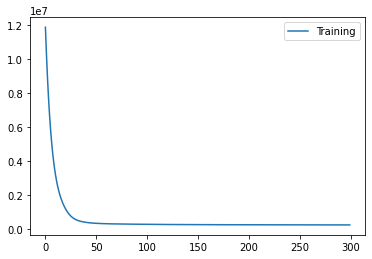

In [ ]:
# Your plotting here
from matplotlib import pyplot as plt
plt.plot(losses)
plt.legend(["Training"])
plt.show()

<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher before proceeding</b>
</div>

### Validation (Similarity)

Curious to see what this network has learned? Let's perform a simple validation experiment. 

We will check which words the models considers the most similar to other words. To that end, we need a notion of __similarity__. One of the most common measures of similarity in high dimensional vector spaces is the cosine similarity. 

The cosine similarity of two vectors $\vec{a}, \vec{b}$ is given as:
$$sim(\vec{a}, \vec{b}) = \frac{\vec{a}\cdot \vec{b}}{|\vec{a}|_2 \cdot |\vec{b}|_2}$$

where $|\vec{x}|_2$ is the $L_2$-norm of the $\vec{x}$.

The function `similarity` below accepts two words, a vocabulary and the network's output vectors, and computes the similarity between these two words.

In [ ]:
def similarity(word_i: str, word_j: str, vocab: Dict[str, int], vectors: FloatTensor) -> float:
    i = vocab[word_i]
    j = vocab[word_j] 
    v_i = vectors[i] / torch.norm(vectors[i], p=2)  # a/|a|
    v_j = vectors[j] / torch.norm(vectors[j], p=2)  # b/|b|
    sim = torch.mm(v_i.view(1, -1), v_j.view(-1, 1)).item()
    return sim

Let's check out some examples. Consider the word pairs below and, optionally, add your own word pairs:

In [ ]:
word_vectors = network.get_vectors().detach()

for pair in [
    ("cruciatus", "imperius"), 
    ("avada", "kedavra"), 
    ("hogwarts", "school"), 
    ("goblin", "hagrid"), 
    ("giant", "hagrid"),
]:
    
    print("Similarity between '{}' and '{}' is: {}".
          format(pair[0], pair[1], similarity(pair[0], pair[1], vocab, word_vectors)))

Similarity between 'cruciatus' and 'imperius' is: 0.46702688932418823
Similarity between 'avada' and 'kedavra' is: 0.825108528137207
Similarity between 'hogwarts' and 'school' is: 0.8492355346679688
Similarity between 'goblin' and 'hagrid' is: 0.006633872631937265
Similarity between 'giant' and 'hagrid' is: 0.4974243938922882


**Interpretation 3**: Give a brief interpretation of the results. Do the scores correspond well to your perceived similarity of these word pairs?

1) Both cruciatus and imperius are an unforgivable curse in the context of Harry Potter. Because both belong to the same group of curses, it explain why the precieved similarity between the two words is relatively high (0.679) but not too high as they are not 

2) The similarity between avada and kedavra is high, with a similarity score of 0.72. This means that the words have a higher chance of occuring together than by themselves. It is expected that these words have a higher similarity than 0.72 because the words avada and kedavra together form one spell and, therefore, are almost exclusively used together.

3) Hogwarts is the School of Witchcraft and Wizardry. It should be expected that the word Hogwarts and school appear often together. The similarity between Hogwart and school is 0.78, highly related as expected.

4) As expected the score for 'goblin' and 'Hagrid' is roughly the same as the perceived similarity as both words are used in different contexts but do have some overlap (the bank scene at the start of book 1).

5) The similarity between giant and hagrid is 0.35. This means that these two words do not often occur together. Despite the fact that hagrid is a half-giant, this is not often mentioned in the book and therefore the combination does not occur together very often. However, hagrid is mentioned often and therefore the denominator of the similarity formula is much higher than the nominator and the similarty is low.

To obtain the similarities of one word against all other words in the corpus, we may rewrite the above equation as:
$$sim(\vec{w}, \mathbf{C}) = \frac{\vec{w}\cdot \mathbf{C}}{|\vec{w}|_2 \cdot |\mathbf{C}|_2}$$

**Coding 9**: Using `similarity` as a reference, write `similarities`, which accepts one word, a vocabulary and the network's output vectors and computes the similarity between the word and the entire corpus.

_Hint_: $\mathbf{C} \in \mathbb{R}^{N, D}$, $\vec{w} \in \mathbb{R}^{1, D}$, $sim(\vec{w}, \mathbf{C}) \in \mathbb{R}^{1, N}$

In [ ]:
def similarities(word_i: str, vocab: Dict[str, int], vectors: FloatTensor) -> FloatTensor:
    i = vocab[word_i]
    v_i = vectors[i] / torch.norm(vectors[i], p=2)  # a/|a|
    C2 = torch.sqrt(torch.sum(vectors*vectors, dim=1))

    left = vectors[i] / torch.norm(vectors[i], p=2)
    right = vectors / C2[:,None]

    right = torch.transpose(right,1,0)
    #sim = torch.mm(v_i.view(1, -1), C_i.view(-1, 1)).item()
    return left @ right

<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher before proceeding</b>
</div>

Now we can manipulate the word vectors to find out what the corpus-wide most similar words to a query word are!

In [ ]:
def most_similar(word_i: str, vocab: Dict[str, int], vectors: FloatTensor, k: int) -> List[str]:
    sims = similarities(word_i, vocab, vectors)
    _, topi = sims.topk(dim=-1, k=k)
    topi = topi.view(-1).cpu().numpy().tolist()
    inv = {v: i for i, v in vocab.items()}
    return [inv[i] for i in topi if inv[i] != word_i]

In [ ]:
for word in [
    "forbidden", "myrtle", "gryffindor", "wand", "quidditch", "marauder",
    "horcrux", "phoenix", "triwizard", "screaming", "letter"
]:
    print("Most similar words to '{}': {}".format(word, most_similar(word, vocab, word_vectors, 6)))

Most similar words to 'forbidden': ['forest', 'trees', 'castle', 'tree', 'follow']
Most similar words to 'myrtle': ['toilet', 'bathroom', 'moaning', 'peeves', 'ignoring']
Most similar words to 'gryffindor': ['ravenclaw', 'slytherin', 'match', 'points', 'gryffindors']
Most similar words to 'wand': ['drawn', 'inches', 'faster', 'ready', 'harry']
Most similar words to 'quidditch': ['match', 'field', 'starting', 'prospect', 'win']
Most similar words to 'marauder': ['cupboard', 'tapestry', 'extra', 'map', 'floor']
Most similar words to 'horcrux': ['fake', 'sword', 'treasure', 'goblin', 'safe']
Most similar words to 'phoenix': ['fawkes', 'feather', 'order', 'connection', 'flames']
Most similar words to 'triwizard': ['tournament', 'final', 'tasks', 'champion', 'task']
Most similar words to 'screaming': ['directly', 'stopping', 'bellowed', 'vision', 'crash']
Most similar words to 'letter': ['envelope', 'hedwig', 'written', 'stuck', 'owl']


**Interpretation 4**: Interpret the results.
- Do these most similar words make sense (are they actually similar to the query words)? 
- Are there any patterns you can see in the "errors" (the words that you woudn't consider actually similar to the query word)? 
- Would you say that the model captures similarity, relatedness, both or neither?
- Any other observations are welcome.

Illustrate your answers with examples from your model's output.

1) The most similar words make a lot of sense for a lot of the words. However, for most words they are not really similar to the words in meaning, but more related on a contextual level. For example, the meaning of "forest" is not similar to the meaning of "forbidden", but they are related in the sense that there is a "forbidden forest" in Harry Potter. This hold true for most of the word relations. An example for similarity would be the words that are most similar to "gryffindor" as both "ravenclaw" and "slytherin" are a one of the four houses of Hogwards. However, these words are again not similar in the sense that they represent the exact same thing like "small" and "little" which are synonyms of eachother, but rather represent the same relation as they are all three a house of Hogwards.

2) There are some patterns in the similar words that are not necessarily related to the target word but merely often occur in the same context as the target word. for instance: the target word 'screaming' has nothing to do with 'directly' or 'vision', but still these words have a high similarity because they occur in the same context. In harry potter harry sometimes has visions of people screaming. Also the target word 'horcrux' has nothing semantically to do with 'goblin' or 'safe', but these often occur in the same context as the goblins are keepers of the safe in which a horcrux is kept. Therefore, the similarity is high while the meaning is not very similar.

3) The model captures similarity because it's based on context and doesn't actually capture any meaning of the words. For that the model would have to have an internal, manipulable representation of the world equivalent to our systems of concepts. Even if the model would also use grammatical tags, it fails to use whatever we see as 'understanding of the meaning'

4) Other observation: while the plurals of words have a high similarity with target words, they are not classified as similar because they don't often occur in the same context. Often either a singular or plural form is used for a word and not both.


Overall it's quite impressive; we managed to encode a meaningful portion of the corpus statistics in only $30$ numbers per word! 
(A compression ratio of 99.4%)

<div class="alert alert-block alert-info">
<b>Note:</b> The word vectors obtained by this process are (to a small extent) random, due to the random initialization of the embedding layers. If you are unhappy with your results, you can repeat the experiment a few times or try to toy around with the hyper-parameters (the smoothing factor of ${X}$, $x_{max}$, $\alpha$, the number of epochs and the dimensionality of the vector space).
</div>

Word vectors, however, contain way more information than just word co-occurrence statistics. Hold tight until the next assignment, where we will see how word vectors may be used to infer information spanning entire phrases and sentences.

### Validation (Word Analogies)

From the paper:
> The word analogy task consists of questions like "$a$ is to $b$ as is $c$ to $?$" To correctly answer this question, we must find the word $d$ such that $w_d \approx w_b - w_a + w_c$ according to the cosine similarity.

**Coding 10**: Write your own function that performs the word analogy task.

_Hint_: Take a look at the code a few cells back. Most of what you need is already there.

In [ ]:
def analogy(
    word_a: str, word_b: str, word_c: str, vocab: Dict[str, int], vectors: FloatTensor, k: int
) -> List[str]:
    a = vocab[word_a]
    b = vocab[word_b]
    c = vocab[word_c]

    wd = vectors[b] - vectors[a] + vectors[c]

    return most_similar_for_analogy(wd, word_c, vocab, vectors, k)
    # call function similarity with wd 
    # wd doorgeven, return highest
    # geeft int door


def similarities_for_analogy(wd_i: int, vocab: Dict[str, int], vectors: FloatTensor) -> FloatTensor:
    v_i = wd_i / torch.norm(wd_i, p=2)  # a/|a|
    C2 = torch.sqrt(torch.sum(vectors*vectors, dim=1))
    left = wd_i / torch.norm(wd_i, p=2)
    right = vectors / C2[:,None]
    right = torch.transpose(right,1,0)
    #sim = torch.mm(v_i.view(1, -1), C_i.view(-1, 1)).item()
    return left @ right

def most_similar_for_analogy(wd_i: int, word_c: str, vocab: Dict[str, int], vectors: FloatTensor, k: int) -> List[str]:
    sims = similarities_for_analogy(wd_i, vocab, vectors)
    _, topi = sims.topk(dim=-1, k=k)
    topi = topi.view(-1).cpu().numpy().tolist()
    inv = {v: i for i, v in vocab.items()}
    return [inv[i] for i in topi if inv[i] != word_c]

<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher before proceeding</b>
</div>

Some example triplets to test your analogies on:

In [ ]:
triplets = [("padma", "parvati", "fred"),
            ("avada", "kedavra", "expecto"),
            ("dungeon", "slytherin", "tower"),
            ("scabbers", "ron", "hedwig"),
            ("ron", "molly", "draco"),
            ("durmstrang", "viktor", "beauxbatons"),
            ("snape", "potions", "trelawney"),
            ("harry", "seeker", "ron")
           ]

for a, b, c in triplets:
    print("'{}' is to '{}' as '{}' is to {}".format(a, b, c, analogy(a, b, c, vocab, word_vectors, 6)))

'padma' is to 'parvati' as 'fred' is to ['weasley', 'angrily', 'away', 'm', 've']
'avada' is to 'kedavra' as 'expecto' is to ['patronum', 'patronus', 'vapor', 'wand:', 'erupted']
'dungeon' is to 'slytherin' as 'tower' is to ['gryffindor', 'slytherin', 'ravenclaw', 'lead', 'quidditch']
'scabbers' is to 'ron' as 'hedwig' is to ['harry', 'ron', 'just', 'wondering', 'relieved', 'hermione']
'ron' is to 'molly' as 'draco' is to ['curling', 'pleading', 'resentful', 'defensively', 'molly', 'sisters']
'durmstrang' is to 'viktor' as 'beauxbatons' is to ['viktor', 'grinned', 'ball', 'davies', 'krum']
'snape' is to 'potions' as 'trelawney' is to ['potions', 'subject', 'herbology', 'sixth', 'disgruntled']
'harry' is to 'seeker' as 'ron' is to ['captain', 'oliver', 'match', 'seeker', 'mud', 'quidditch']


Some minimal emergent intelligence :) *(hopefully..)*. 🧙‍♀️

**Interpretation 5**: Interpret the results. 
- Did the model manage to guess the correct answers to the analogies (taking the first word in the output to be the model's "guess")? 
- Are the correct answers present in the top K words? 
- Do you see any patterns in the cases when the model didn't solve the task correctly? In other words, when the model's guess was wrong, can you suggest why the model guessed what it guessed?

1) The model managed to gues the correct analogies in most cases as "scabbers" and "ron" have the same relation as "hedwig" and "harry" as they both have the realtion of being the pet of one another. The same is true for: "avada kadavra" and "expecto patronum", "dungeon slytherin" and "tower gryffindor", "harry seeker" and "ron captain". All of these anagolies are correct in the sense that they represent the same relation between the words. There are however some cases that are not correct, for example, the relation of "padma" and "parvati" is not the same as the relation of "fred" and "weasley" as "padma" and "parvati" are sisters, but "weasley" is the last name of "fred".

2) for most cases, the correct answers are present in the top K words. For instance, in avada is to kedavra as expecto is to 'patronum'. patronum is the best hit and also the correct answer. Also, the dungeon to slytherin as tower is to gryffindor is correct and harry is to seeker as ron is to captain is correct.

However, a few instances are not correct. Padma is to pervati as fred is to 'george', but george is not part of the list. Also, snape is to potions as trelawney is to 'divinations', but divinations in not present in the top K words.

So, in most cases the correct answer is present but not in all.

3) In cases where the first two words co-occur very frequently (like 'padma' and 'parvati') the difference in context is so small that there isn't a clear direction given to the third word, so 'fred' becomes 'weasly' (after filtering out the third word, so 'fred', which it would've been because the change is so small). 'Weasly' simply co-occurs much more frequently in the same context with 'fred' than 'george' does, and the algorithm does't really search for anything else than simply sharing the same context.

Similarly, when 'Durmstrang', 'viktor' and 'beauxbatons' is the input the output is 'viktor'. This is again due to the algorithm looking purely for (somewhat) shared contexts.

### Optional
If you are done, you can continue experimenting in order to understand the system's behaviour better. For example: how does training and hyperparameter choice affect the model's performance?
Repeat the training using your own hyperparameters (vector space dimensionality, optimizer parameters, the number of training epochs, etc.). 

During the training loop, print the qualitative benchmarks every few epochs. Do they keep improving? Is there any disadvantage to exhaustively training until convergence?